### Import Dependencies

In [1]:
import h5py
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.utils import np_utils
from keras import utils

#### avoid oom errors by setting gpu memory consumption growth

In [2]:
# grab all the gpus available in the machine
gpus = tf.config.experimental.list_physical_devices('GPU')
# for every gpu set memory growth (making tensorflow to keep the memory only to what it needs)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Dataset

I will be using the Galaxy10 SDSS Dataset from [astroNN](https://astronn.readthedocs.io/en/latest/index.html). The dataset can be found here: http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5  
The dataset contains 21785 69x69 pixels colored galaxy images separated in 10 classes as shown below:  

Galaxy10 dataset (21785 images)  
├── Class 0 (3461 images): Disk, Face-on, No Spiral  
├── Class 1 (6997 images): Smooth, Completely round  
├── Class 2 (6292 images): Smooth, in-between round  
├── Class 3 (394 images): Smooth, Cigar shaped  
├── Class 4 (1534 images): Disk, Edge-on, Rounded Bulge  
├── Class 5 (17 images): Disk, Edge-on, Boxy Bulge  
├── Class 6 (589 images): Disk, Edge-on, No Bulge  
├── Class 7 (1121 images): Disk, Face-on, Tight Spiral  
├── Class 8 (906 images): Disk, Face-on, Medium Spiral  
└── Class 9 (519 images): Disk, Face-on, Loose Spiral  

Images come from [Sloan Digital Sky Survey](https://www.sdss.org/) and labels from [Galaxy Zoo](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/).

In [3]:
# get the images and labels from file
with h5py.File('dataset/Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# convert to desirable type
labels = labels.astype(np.uint8)
images = images.astype(np.uint8)

### Visualize Dataset

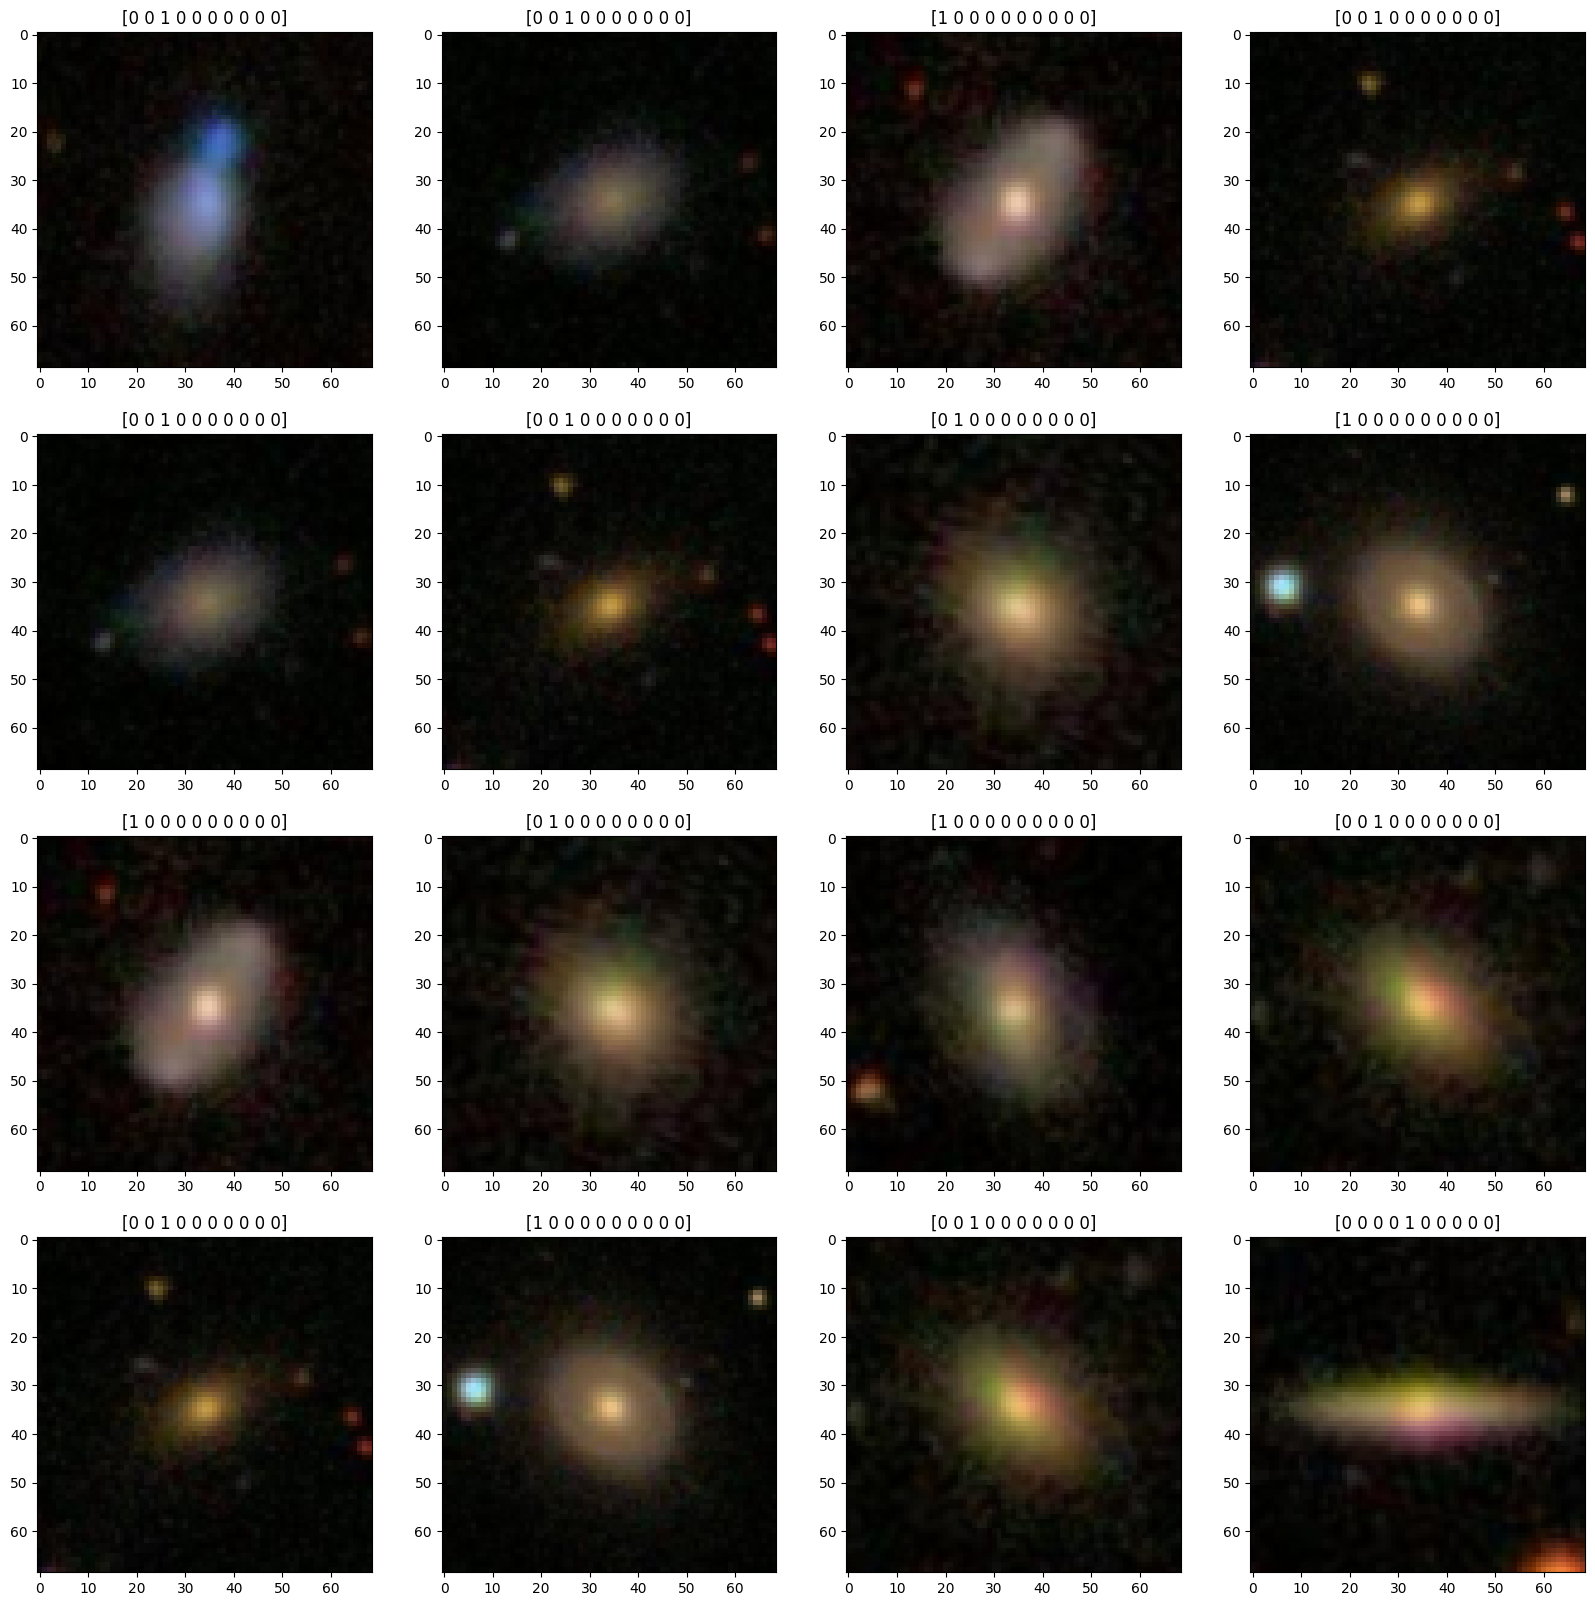

In [4]:
# get 16 random images
num_images = images.shape[0]
random_images = random.sample(range(num_images), 16)
# get their corresponding labels
img = images[random_images]
random_labels = [str(label) for label in labels[random_images]]

# visualize them
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20,20))
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(img[(i+1)*(j+1)-1])
        ax[i][j].title.set_text(random_labels[(i+1)*(j+1)-1])
plt.show()

### Scale the images

In [5]:
def scale_images(image):
    return image / 255

#### cache/shuffle/batch/prefetch

In [6]:
# Convert the numpy array to a `tf.data.Dataset` object
images = tf.data.Dataset.from_tensor_slices(images)

# run images through the scaling function
images = images.map(scale_images)
# cache images for that batch
images = images.cache()
# shuffle the images
images = images.shuffle(60000)
# batch them into 128 images per sample
images = images.batch(128)
# reduces the likelihood of bottlenecking
images = images.prefetch(64)

### Build the Generator

In the GAN model we need a generator. The generator's purpose is to take random noise as input and generate new samples that are similar to the training data (meaning our images from the dataset). By doing so the generator can then fool the discriminator (which we will also build later) into thinking they are real data samples. The goal is for the generator to "compete" with the discriminator and over time both of them get better and better. If the generator is not able to "fool" the discriminator it means that the sample is not very realistic and needs further improvement.

In [7]:
# Load the modeling components
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [8]:
def build_generator():
    model = Sequential()                       # define our model
    model.add(Dense(17*17*128, input_dim=128)) # add Dense layer with random noise as input
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation
    model.add(Reshape((17,17,128)))            # reshape to 17*17*128

    # Upsampling block - 1
    model.add(UpSampling2D())                  # layer used to increase the spatial resolution of the input
    model.add(Conv2D(128, 5, padding='same'))  # convolutional nn layer with 128 units, kernel size 5x5 and padding same
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation

    # Upsampling block - 2
    model.add(UpSampling2D())                  # layer used to increase the spatial resolution of the input
    model.add(Conv2D(128, 5, padding='same'))  # convolutional nn layer with 128 units, kernel size 5x5 and padding same
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation

    # Downsampling block - 1
    model.add(Conv2D(128, 4, padding='same'))  # convolutional nn layer with 128 units, kernel size 4x4 and padding same
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation

    # Downsampling block - 2
    model.add(Conv2D(128, 4, padding='same'))  # convolutional nn layer with 128 units, kernel size 4x4 and padding same
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation

    # convolutional nn layer to change to 3 channels,kernel size 4x4, same padding and a sigmoid activation this time
    model.add(Conv2D(3, 4, padding='same', activation='sigmoid'))

    # return the model
    return model

#### Generator summary

In [9]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 36992)             4771968   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 36992)             0         
                                                                 
 reshape (Reshape)           (None, 17, 17, 128)       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 34, 34, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 34, 34, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 34, 34, 128)       0         
                                                        

#### Generate 4 random images

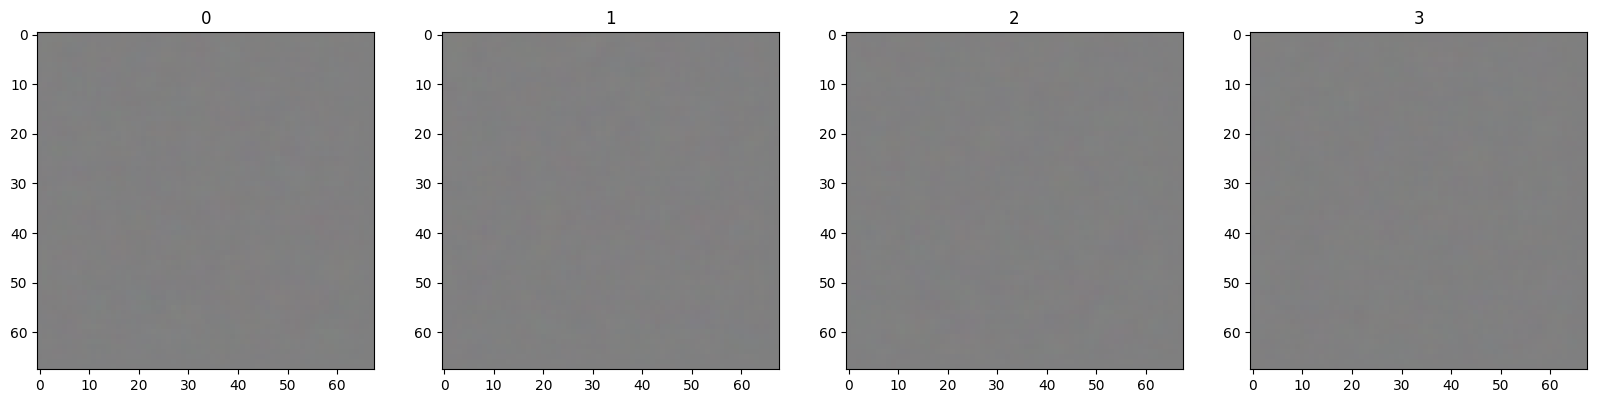

In [10]:
img = generator.predict(np.random.randn(4, 128, 1), verbose=0)
# get data out of the pipeline and visualize
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# loop through images
for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

### Build the Discriminator

In the GAN model we also need a discriminator. The discriminator's purpose is distinguishing between the generated (meaning the fake images) and the real images. It is trained to classify images as either real or fake and its feedback is used to train the generator and produce even better images. By training them simultaneously the GAN model is able to generate better and better images over time.

In [11]:
def build_discriminator():
    model = Sequential()                            # define our model

    # convolutional block - 1
    model.add(Conv2D(32, 5, input_shape=(68,68,3))) # convolutional nn layer with 32 units, kernel size 5x5 and input size of our data
    model.add(LeakyReLU(0.2))                       # apply LeakyRelu activation
    model.add(Dropout(0.4))                         # apply Dropout for reguralizaion (prevents overfitting)

    # convolutional block - 2
    model.add(Conv2D(64, 5))                        # convolutional nn layer with 64 units, kernel size 5x5
    model.add(LeakyReLU(0.2))                       # apply LeakyRelu activation
    model.add(Dropout(0.4))                         # apply Dropout for reguralizaion (prevents overfitting)
 
    # convolutional block - 3
    model.add(Conv2D(128, 5))                       # convolutional nn layer with 128 units, kernel size 5x5
    model.add(LeakyReLU(0.2))                       # apply LeakyRelu activation
    model.add(Dropout(0.4))                         # apply Dropout for reguralizaion (prevents overfitting)

    # convolutional block - 4
    model.add(Conv2D(128, 5))                       # convolutional nn layer with 128 units, kernel size 5x5
    model.add(LeakyReLU(0.2))                       # apply LeakyRelu activation
    model.add(Dropout(0.4))                         # apply Dropout for reguralizaion (prevents overfitting)

    # flatten and then pass to one Dense layer
    model.add(Flatten())                            # Flattens output (takes the output of the last convolutional layer and converts from 3D tensor to 1D tensor)
    model.add(Dropout(0.4))                         # apply Dropout for reguralizaion (prevents overfitting)
    model.add(Dense(1, activation='sigmoid'))       # Dense layer for final decision based on the features learned by the previous layers (1 for false image and 0 for real image)

    # return the model
    return model

#### Discriminator summary

In [12]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        2432      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 60, 60, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 60, 60, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 128)      